In [28]:
!pip install CFEDemands

import cfe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Team David Zilberman: Price Change Calcium Nutrition Analysis

#### Hello! 
Goal for this piece of analysis: analyzing changes in nutrition distributions for changes in price. The main policy instrument we are proposing is an import subsidy for Milk, based on the lack of calcium available in Tanzania and the subsequently devastating health effects. In this notebook, I'll provide some backing for our choice to look at Calcium specifically, and then work through a process trying to estimate population changes. Things are still in the works, and appreciate any feedback/ideas/thoughts you may have! 

#### Acknowledgement: 
We are using data-sets for Tanzania and some code graciously shared by Project 3's Stanley Jevons group, specifically Vishali. She is awesome and a very talented coder.

In [29]:
pwd

'/home/jovyan/DavidZilberman/For_Review'

#### Load in Datasets and Reformat Indices

In [30]:
# Reading the food expenditures dataset for Tanzania
x_tanzania = pd.read_csv("Data/Tanzania [Reformatted] - Food Expenditures (2019-20).csv")

# If the 'm' column is not present, add it and set its values to 1
if 'm' not in x_tanzania.columns:
    x_tanzania['m'] = 1

# Setting a multi-level index
x_tanzania = x_tanzania.set_index(['i', 't', 'm'])
x_tanzania.columns.name = 'j'

# Converting all columns to numeric, coercing errors to NaN
x_tanzania = x_tanzania.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# Replacing 0 values with NaN
x_tanzania = x_tanzania.replace(0, np.nan)

# Reading the household characteristics dataset for Tanzania
z_tanzania = pd.read_csv("Data/Tanzania [Reformatted] - Household Characteristics (2019-20).csv")

# If the 'm' column is not present, add it
if 'm' not in z_tanzania.columns:
    z_tanzania['m'] = 1

# Setting a multi-level index
z_tanzania = z_tanzania.set_index(['i', 't', 'm'])
z_tanzania.columns.name = 'k'

# Converting all columns to numeric, coercing errors to NaN
z_tanzania = z_tanzania.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# Assuming the 'new.csv' file is related to Tanzania's price data. The original naming wasn't clear.
p_tanzania = pd.read_csv("Data/new.csv")

# If the 'm' column is not present, add it
if 'm' not in p_tanzania.columns:
    p_tanzania['m'] = 1

# Setting a multi-level index
p_tanzania = p_tanzania.set_index(['t', 'm'])
p_tanzania.columns.name = 'j'

# Converting all columns to numeric, coercing errors to NaN
p_tanzania = p_tanzania.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# Replacing 0 values with NaN
p_tanzania = p_tanzania.replace(0, np.nan)

# Reading the Food Consumption Table (FCT) for Tanzania
fct_tanzania = pd.read_csv("Data/Tanzania [Reformatted] - FCT.csv")

rdi_tanzania = pd.read_csv("Data/Uganda - RDI.csv")

# Setting 'j' as the index
fct_tanzania = fct_tanzania.set_index('j')
fct_tanzania.columns.name = 'n'

# Converting all columns to numeric, coercing errors to NaN
fct_tanzania = fct_tanzania.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# Setting 'n' as the index
rdi_tanzania = rdi_tanzania.set_index('n')
rdi_tanzania.columns.name = 'k'

# Running the CFE (Cost of Basic Needs) regression for Tanzania
result_tanzania = cfe.Regression(y=np.log(x_tanzania.stack()), d=z_tanzania)

#### Get predicted expenditures and translate to estimate for nutritional consumption in Tanzania

In [31]:
xhat = result_tanzania.predicted_expenditures() # expenditure

qhat = (xhat.unstack('j')/p_tanzania).dropna(how='all') # grab quantities

qhat = qhat.loc[:,qhat.count()>0] # get all for > 0 

use = fct_tanzania.index.intersection(qhat.columns) # only use same food indices 

nutrients = qhat[use]@fct_tanzania.loc[use,:] # select same nutrients as FCT
nutrients.mean() 

z = z_tanzania[rdi_tanzania.columns.tolist()] # household characteristics 

hh_rdi = z@rdi_tanzania.T # matrix multiply households by RDI

hh_rwi = hh_rdi*7 # translate for RDI

use_nutrients = nutrients.columns.intersection(hh_rwi.columns) # use same indices

nutrient_ratio_tanzania = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna() # get nutrient ratios

#### Wanted to look at the averages, just to see which nutrient was lowest.

In [32]:
averages = nutrient_ratio_tanzania.mean()
sorted_averages = averages.sort_values(ascending=False)
print(f'Nutrient Ratios in Tanzania: \n' + str(sorted_averages))

Nutrient Ratios in Tanzania: 
n
Carbohydrate    3.687684
Vitamin B-6     1.765379
Protein         1.753266
Energy          1.529042
Vitamin B-12    1.500087
Niacin          1.323610
Thiamin         1.227067
Zinc            1.052872
Riboflavin      1.033971
Iron            0.953520
Vitamin C       0.827692
Fiber           0.788032
Folate          0.716731
Vitamin A       0.420803
Calcium         0.355245
dtype: float64


As we can see, this averaged set's lowest nutritional requirement based on the RDI is Calcium. Now, let's identify foods that we can use to approach this calcium deficiency. 

In [33]:
calcium_foods = fct_tanzania.sort_values('Calcium', ascending=False)[['Calcium']]
calcium_foods[0:10]

n,Calcium
j,
Bread,1510
"Buns, Cakes And Biscuits",1300
Milk (fresh),1130
Milk (dry or canned),1130
Nuts,710
Eggs,530
Sweet Potatoes,430
Rice (paddy),330
Cassava (flour),310


Okay! Because of nutritional fulfillment of Bread-based calcium, we decided to approach the problem with Milk, and then hopefully fish. We are still investigating if there are other foods/methods to do this better.

### Estimating Nutrition for Changes in Price

Here, I wrote out a function that takes as input a certain percent change in the price of a food, and that food as a string, and then calculates the predicted change in nutrition based on expenditure data (with demand.) This was very difficult, as indexing with the \textttt{cfe} package was tricky, but I think I got it working. But please, poke around. I'm not 100% sure of the results, or if it's dispensing valid stuff, but thankfully, the nutrition levels DO change for increasing drops in the price of food. 

In [34]:
def my_prices(p0,p,j='food'): # use Ligon's my_prices function
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

In [35]:
def PriceDrop2NutritionRatio(price_drop_percentage, food = 'food'): # enter percentage price drop as float

    # GETTING BUDGETS
   
    xhat = result_tanzania.predicted_expenditures() # get expenditures 
    xbar = xhat.groupby(['i','t','m']).sum() # set indices 
    x_budgets = xbar.quantile(np.linspace(.01,.99,20)) # get income budgets, here over 20 percetile ranks

    # DROPPING PRICE OF FOOD
    
    p_drop = p_tanzania.copy() # copy original price table     
    p_drop[food] = p_drop[food]*(1 - price_drop_percentage) # reduce price by percentage    
    p_drop_mean = p_drop.mean() # average prices
    pbar_dropped = p_drop_mean[result_tanzania.beta.index] # take ones we can run demands for
    
    # GETTING NUTRIENT RATIOS
    
    ratios = [] # make empty list to store ratio values
    for x in x_budgets:
        qhat = result_tanzania.demands(x, my_prices(pbar_dropped.loc[food], p = pbar_dropped, j = food)) # get quant demanded for new price
        use = fct_tanzania.index.intersection(qhat.index) # set new index where FCT and quantity dataframes have same
        nutrients = qhat[use]@fct_tanzania.loc[use,:] # matrix-multiply the quantity times the nutrients 
        z = z_tanzania[rdi_tanzania.columns.tolist()] # get RDI column names 
        hh_rdi = z@rdi_tanzania.T # get household RDIs per household
        hh_rwi = hh_rdi*7 # set new RDI 
        use_nutrients = nutrients.index.intersection(hh_rwi.columns) # only use nutrients where index/columns same
        nutrient_ratios = (nutrients[use_nutrients]/hh_rwi[use_nutrients]) # calculate ratio
        ratios.append(nutrient_ratios.mean()['Calcium']) # append to ratios list 
    
    return ratios

Now, try out the function for price reductions of 0.01, 0.5: 

In [36]:
try_001 = np.array(PriceDrop2NutritionRatio(0.01, food = 'Milk (fresh)'))
try_095 = np.array(PriceDrop2NutritionRatio(0.95, food = 'Milk (fresh)'))

In [37]:
try_001

array([0.13058455, 0.18707965, 0.2177911 , 0.24542129, 0.27326271,
       0.29363407, 0.31474076, 0.32840535, 0.34426931, 0.36047576,
       0.37931018, 0.39750992, 0.41352062, 0.43470233, 0.46011315,
       0.48651069, 0.52179798, 0.57816954, 0.65953758, 1.04866579])

In [38]:
try_095

array([0.2073412 , 0.29970024, 0.34977328, 0.39470097, 0.43983926,
       0.47277599, 0.50681742, 0.52880931, 0.55429412, 0.58027677,
       0.61040571, 0.63945072, 0.66494638, 0.69859613, 0.73884407,
       0.78051681, 0.83600591, 0.92414262, 1.05029402, 1.63796214])

In [39]:
import seaborn as sns
sns.set_theme()

Now let's see what this looks like. 

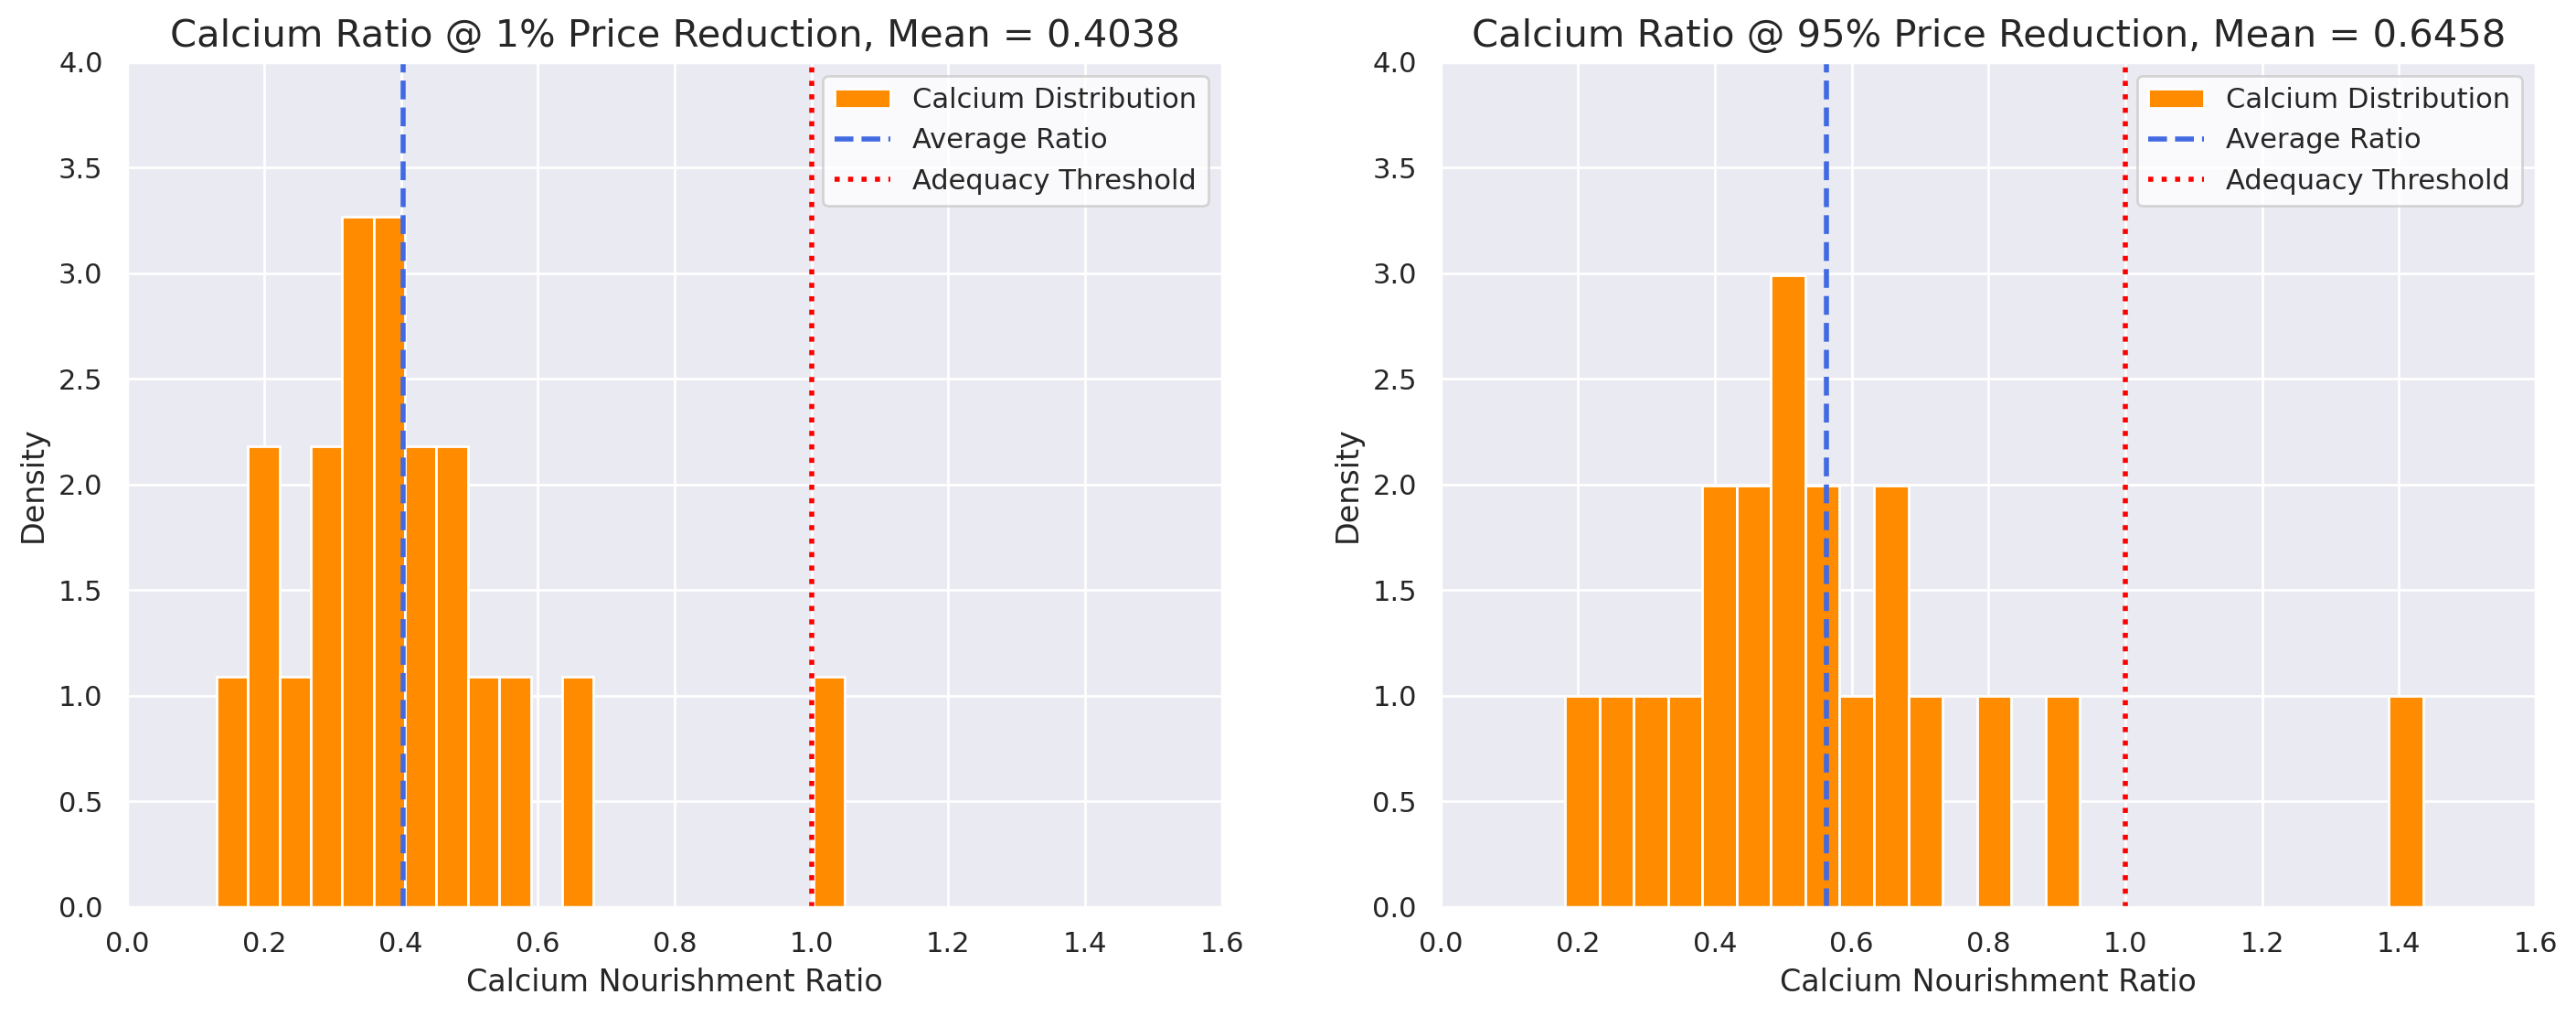

In [52]:
fig, ax = plt.subplots(1,2, figsize = (17,6), dpi=200)

ax[0].hist(try_001, bins = 20, density = True, label = 'Calcium Distribution', color = 'darkorange')
ax[0].set_title(f'Calcium Ratio @ 1% Price Reduction, Mean = {try_001.mean():.4f}'.format(str), fontsize = 15)
ax[0].axvline(try_001.mean(), lw = 2, ls = 'dashed', color = 'royalblue', label = 'Average Ratio')
ax[0].axvline(1, lw = 2, ls = 'dotted', color = 'red', label = 'Adequacy Threshold')
ax[0].legend(facecolor = 'white')


ax[1].hist(try_09, bins = 25, density = True, label = 'Calcium Distribution', color = 'darkorange')
ax[1].set_title(f'Calcium Ratio @ 95% Price Reduction, Mean = {try_095.mean():.4f}'.format(str), fontsize = 15) # I know this is not realistic 
ax[1].axvline(try_09.mean(), lw = 2, ls = 'dashed', color = 'royalblue', label = 'Average Ratio')
ax[1].axvline(1, lw = 2, ls = 'dotted', color = 'red', label = 'Adequacy Threshold')
ax[1].legend(facecolor = 'white')

plt.setp(ax, xlabel = 'Calcium Nourishment Ratio', ylabel = 'Density', xlim = (0, 1.6), ylim = (0,4))
plt.savefig('Milk_Price_Reduction.png')

Okay, so function seems like it's working! Now let's see what happens across all price changes, just to recheck if function is working and if this is even a good strategy... 

In [54]:
price_drop_percentages = np.arange(0, 1, 0.05) # array to pass through as percentage changes in price
price_drop_percentages

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

Now apply those price changes to foods with the function. This cell takes an extra second to run! 

In [55]:
averages_milk = [] # empty list to store averages 
for i in range(len(price_drop_percentages)):
    nutrition = np.array(PriceDrop2NutritionRatio(price_drop_percentages[i], food = 'Milk (fresh)')) # apply function to Milk 
    averaged = nutrition.mean() # take average 
    averages_milk.append(averaged) # append to list 

milk_avg_dict = {'Price Reduction %': price_drop_percentages, # define dictionary for DataFrame
                'Average Nutrition Ratio': averages_milk}

# averages_fish = [] # empty list to store averages 
# for i in range(len(price_drop_percentages)):
#     nutrition = np.array(PriceDrop2NutritionRatio(price_drop_percentages[i], food = 'Fish (fresh)')) # apply function to Fish
#     averaged = nutrition.mean() # take average 
#     averages_fish.append(averaged) # append to list

# fish_avg_dict = {'Price Reduction %': price_drop_percentages, # define dictionary for DataFrame
#                 'Average Nutrition Ratio': averages_fish}

milk_avgs = pd.DataFrame(milk_avg_dict) # Create DataFrames
fish_avgs = pd.DataFrame(fish_avg_dict)

In [17]:
averages_dried_fish = [] # empty list to store averages 
for i in range(len(price_drop_percentages)):
    nutrition = np.array(PriceDrop2NutritionRatio(price_drop_percentages[i], food = 'Fish (dried)')) # apply function to Fish
    averaged = nutrition.mean() # take average 
    averages_dried_fish.append(averaged) # append to list

Now, looking at average nutrition for these price changes: 

In [19]:
milk_avgs

,Price Reduction %,Average Nutrition Ratio
0,0.00,0.403317
1,0.05,0.405668
2,0.10,0.408184
3,0.15,0.410889
4,0.20,0.413810
5,0.25,0.416979
6,0.30,0.420440
7,0.35,0.424243
8,0.40,0.428455
9,0.45,0.433162


In [63]:
milk_avgs['Percentage Increase'] = (milk_avgs['Average Nutrition Ratio'] - milk_avgs['Average Nutrition Ratio'].loc[0])

In [64]:
milk_avgs

,Price Reduction %,Average Nutrition Ratio,Percentage Increase
0,0.00,0.403317,0.000000
1,0.05,0.405668,0.002351
2,0.10,0.408184,0.004867
3,0.15,0.410889,0.007572
4,0.20,0.413810,0.010492
5,0.25,0.416979,0.013662
6,0.30,0.420440,0.017123
7,0.35,0.424243,0.020926
8,0.40,0.428455,0.025138
9,0.45,0.433162,0.029845


In [61]:
def perc_to_pop(percentage): 
    delta_pop_Calc_nourished = (65.5*10**6)*percentage
    return delta_pop_Calc_nourished

In [68]:
perc_to_pop(0.004867)

318788.5

In [67]:
perc_to_pop(0.242457)

15880933.5

### That's it for now! Was going to make a bunch of histograms, but ran out of time. Thanks for your help! Looking for redundancies and ways to improve. 

In [69]:
milk_exp = x_tanzania['Milk (fresh)'].sum()
avg_milk_price = p_tanzania['Milk (fresh)'].mean()
milk_quant = milk_exp/avg_milk_price
print(f'Total Quantity of Milk Demanded = {milk_quant} [kg]'.format(str))

Total Quantity of Milk Demanded = 666.7553191137685 [kg]


In [70]:
fish_exp = x_tanzania['Fish (fresh)'].sum()
avg_fish_price = p_tanzania['Fish (fresh)'].mean()
fish_quant = fish_exp/avg_fish_price
print(f'Total Quantity of Fish = {fish_quant} [kg]'.format(str))

Total Quantity of Fish = 1924.05891527377 [kg]


#### Some unit/currency info: 
- Tanzanian currency are Shillings
- One Shilling = 0.00038 USD
- Milk to import: https://www.alibaba.com/product-detail/Chinese-supplier-wholesales-whole-milk-Premium_1601020537580.html
  - This milk is \$1.52/can for > 500 orders.
  - Each can contains 410g of milk = 0.41 kg
  - To double the quantity demanded of fresh milk in kg, we would need to import 1627 cans of milk.
  - This equates to 1627 x 1.52 = $2472 USD, or 6504930 Tanzanian shillings. 


In [135]:
(milk_quant/0.41)*1.52*7

17303.113647245114

In [136]:
17303.113647245114/0.00038

45534509.59801345

In [137]:
75.73*10**9

75730000000.0

In [147]:
(45534509.59801345/75730000000)*100

0.06012743905719457

In [25]:
p_tanzania['Milk (dry or canned)'].mean()

19305.555556666666

In [26]:
p_tanzania['Milk (fresh)']

t          m                   
2019-20    Dar Es Salaam           2000.000000
2019-20.1  Mainland Other Urban    1266.666667
2019-20.2  Mainland Rural          1000.000000
2019-20.3  Zanzibar                2000.000000
Name: Milk (fresh), dtype: float64

In [27]:
x_tanzania['Milk (dry or canned)'].sum()

68822.91667

In [28]:
68822.91667/19305.555556666666

3.5649280575214433

In [29]:
x_tanzania['Milk (fresh)'].sum()

1044583.3333338001

In [76]:
x_tanzania_Milk_doubled = x_tanzania.copy()

In [115]:
x_tanzania_Milk_doubled['Milk (fresh)'] = x_tanzania['Milk (fresh)']*8

In [116]:
# Running the CFE regression with the doubled expenditures
result_tanzania_doubled = cfe.Regression(y=np.log(x_tanzania_Milk_doubled.stack()), d=z_tanzania)

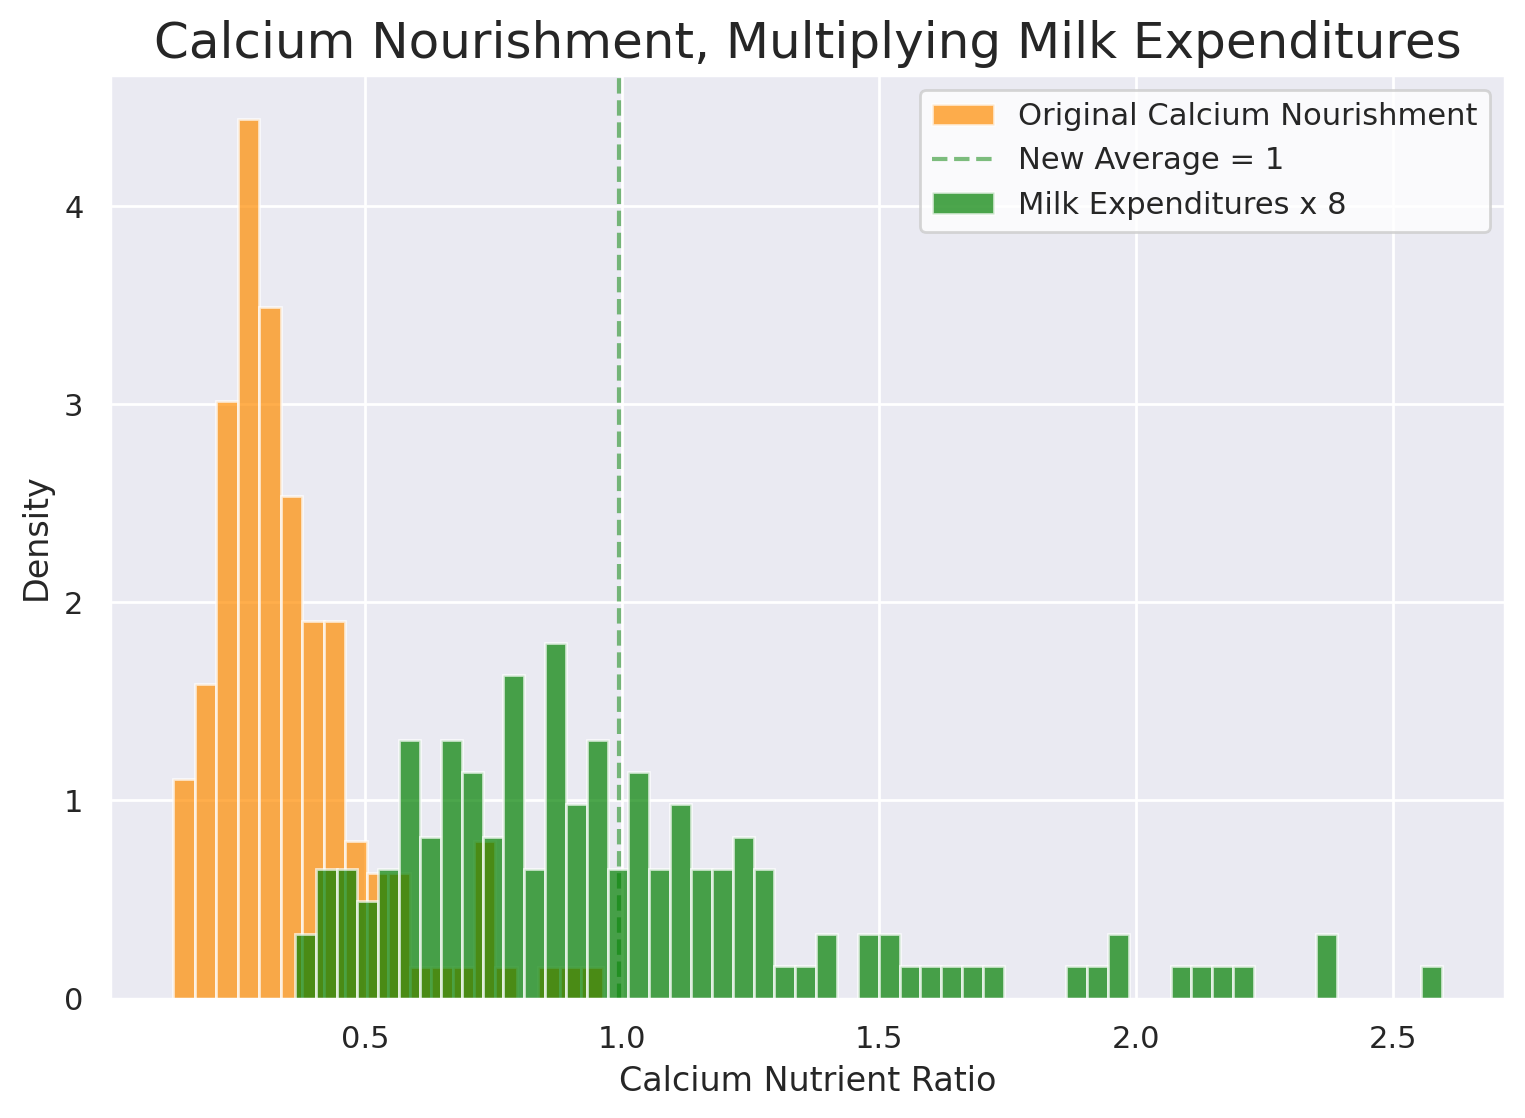

In [133]:
xhat = result_tanzania_doubled.predicted_expenditures()

qhat = (xhat.unstack('j')/p_tanzania).dropna(how='all')

qhat = qhat.loc[:,qhat.count()>0]

use = fct_tanzania.index.intersection(qhat.columns)

nutrients = qhat[use]@fct_tanzania.loc[use,:]
nutrients.mean() 

z = z_tanzania[rdi_tanzania.columns.tolist()]

hh_rdi = z@rdi_tanzania.T

hh_rwi = hh_rdi*7

use_nutrients = nutrients.columns.intersection(hh_rwi.columns)

nutrient_ratio_tanzania_doubled = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()

plt.figure(figsize=(9, 6), dpi=200)

# Plotting the normalized histogram for Uganda's energy nutrient ratio
plt.hist(nutrient_ratio_tanzania['Calcium'], bins=20, alpha=0.7, label='Original Calcium Nourishment', color = 'darkorange', density=True)

# Plotting the normalized histogram for Tanzania's energy nutrient ratio
plt.axvline(np.mean(nutrient_ratio_tanzania_doubled['Calcium']), ls = 'dashed', alpha = 0.5, color = 'green', label = 'New Average = 1')
plt.hist(nutrient_ratio_tanzania_doubled['Calcium'], bins=55, alpha = 0.7, label='Milk Expenditures x 8', color = 'green', density=True)
plt.title('Calcium Nourishment, Multiplying Milk Expenditures', fontsize = 18)

plt.xlabel('Calcium Nutrient Ratio')
plt.ylabel('Density')  # Adjusting label to 'Density' for clarity
plt.legend(loc='upper right', facecolor = 'white')

plt.savefig('milk_exp_multiplied.png')
plt.show()

In [140]:
def PriceDrop2NutritionRatio_multiplied(price_drop_percentage, food = 'food'): # enter percentage price drop as float

    # GETTING BUDGETS
   
    xhat = result_tanzania_doubled.predicted_expenditures() # get expenditures 
    xbar = xhat.groupby(['i','t','m']).sum() # set indices 
    x_budgets = xbar.quantile(np.linspace(.01,.99,20)) # get income budgets, here over 20 percetile ranks

    # DROPPING PRICE OF FOOD
    
    p_drop = p_tanzania.copy() # copy original price table     
    p_drop[food] = p_drop[food]*(1 - price_drop_percentage) # reduce price by percentage    
    p_drop_mean = p_drop.mean() # average prices
    pbar_dropped = p_drop_mean[result_tanzania.beta.index] # take ones we can run demands for
    
    # GETTING NUTRIENT RATIOS
    
    ratios = [] # make empty list to store ratio values
    for x in x_budgets:
        qhat = result_tanzania.demands(x, my_prices(pbar_dropped.loc[food], p = pbar_dropped, j = food)) # get quant demanded for new price
        use = fct_tanzania.index.intersection(qhat.index) # set new index where FCT and quantity dataframes have same
        nutrients = qhat[use]@fct_tanzania.loc[use,:] # matrix-multiply the quantity times the nutrients 
        z = z_tanzania[rdi_tanzania.columns.tolist()] # get RDI column names 
        hh_rdi = z@rdi_tanzania.T # get household RDIs per household
        hh_rwi = hh_rdi*7 # set new RDI 
        use_nutrients = nutrients.index.intersection(hh_rwi.columns) # only use nutrients where index/columns same
        nutrient_ratios = (nutrients[use_nutrients]/hh_rwi[use_nutrients]) # calculate ratio
        ratios.append(nutrient_ratios.mean()['Calcium']) # append to ratios list 
    
    return ratios

In [145]:
pp09 = PriceDrop2NutritionRatio_multiplied(0.9, food = 'Milk (fresh)')

In [146]:
np.mean(pp09)

0.7177893824373788